# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [ ]:
env = UnityEnvironment(file_name="...")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

## 5. Librairies

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd
import numpy as np
import random
import copy
import time
from collections import namedtuple, deque
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
from shutil import copyfile
%matplotlib inline

from IPython.display import clear_output,display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 6. Environment

In [2]:
class Environment():
    
    def __init__(self,path, seed = 0):
        self.env = UnityEnvironment(file_name=path, seed=seed);
        self.brain_name = self.env.brain_names[0]
        self.brain = self.env.brains[self.brain_name]
        # self.state_size = self.brain.vector_observation_space_size # bug, returns 8 :.(
        self.action_size = self.brain.vector_action_space_size
        info = self.env.reset(train_mode=True)[self.brain_name]
        self.state_size = len(info.vector_observations[0])
        self.num_agents = len(info.agents)
        
    def close(self):
        self.env.close()
    
    def reset(self,train=True):
        info = self.env.reset(train_mode=train)[self.brain_name]
        return info.vector_observations
    
    def step(self,action):
        info = self.env.step(action)[self.brain_name]    
        state = info.vector_observations          
        reward = info.rewards 
        done = info.local_done   
        return state, reward, done, info

## 7. Actor-critic architecture

In [3]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units,1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        x = F.relu(self.fc1(state))
        x = torch.cat((x, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## 8. Memory

In [4]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [5]:
class ReplayBufferPrioritized:
    def __init__(self, buffer_size, batch_size, seed, min_delta=1e-5):
        self.seed = random.seed(seed)
        
        self.batch_size = batch_size
        self.min_delta = min_delta
        
        self.buffer = deque(maxlen=buffer_size)
        self.deltas = deque(maxlen=buffer_size)
        
        self.exp_template = namedtuple("exp", field_names=["state","action","reward","new_state","done"])
    
    def add(self, state, action, reward, new_state, done):
        exp = self.exp_template(state, action, reward, new_state, int(done))
        self.buffer.append(exp)
        self.deltas.append( max(self.deltas) if len(self.deltas) > 0 else self.min_delta )
    
    def sample(self,priority=0.5):
        deltas = np.array(self.deltas)
        probs = deltas**priority / np.sum(deltas**priority)
        
        exp_batch_idx = np.random.choice(np.arange(len(self.buffer)), size=self.batch_size, p=probs, replace=False)
         
        states = torch.from_numpy(np.vstack([self.buffer[idx].state for idx in exp_batch_idx])).float().to(device)
        actions = torch.from_numpy(np.vstack([self.buffer[idx].action for idx in exp_batch_idx])).float().to(device)
        rewards = torch.from_numpy(np.vstack([self.buffer[idx].reward for idx in exp_batch_idx])).float().to(device)
        new_states = torch.from_numpy(np.vstack([self.buffer[idx].new_state for idx in exp_batch_idx])).float().to(device)
        dones = torch.from_numpy(np.vstack([self.buffer[idx].done for idx in exp_batch_idx])).float().to(device)
        probabilities = torch.from_numpy(np.vstack([probs[idx] for idx in exp_batch_idx])).float().to(device)
        return states, actions, rewards, new_states, dones, probabilities, exp_batch_idx
    
    def update_deltas(self,idxs,deltas):
        for i,idx in enumerate(idxs):
            self.deltas[idx] = deltas[i] + self.min_delta
    
    def __len__(self):
        return len(self.buffer)

In [6]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        rnd = np.random.standard_normal(self.size)

        dx = self.theta * (self.mu - x) + self.sigma * rnd
        self.state = x + dx
        return self.state

## 9. Agent

In [7]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, num_agents,
                 state_size,
                 action_size,
                 buffer_size,
                 batch_size,
                 learn_every,
                 update_every,
                 random_seed,
                 use_pre):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            buffer_size (int): size of memory
            batch_size (int): size of batch for learning
            learn_every (int): number of step to wait before learning
            update_every (int): number of step to wait before update weights
            random_seed (int): random seed
            use_pre (Boolean) : wether or not use prioritized experience replay
        """
        self.use_pre = use_pre
        self.num_agents = num_agents
        self.state_size = state_size
        self.action_size = action_size
        self.learn_every = learn_every
        self.update_every = update_every
        self.seed = random.seed(random_seed)
        self.buffer_size = buffer_size
        self.batch_size = batch_size

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise((num_agents,action_size), random_seed)

        # Replay memory
        if self.use_pre:
            self.memory = ReplayBufferPrioritized(self.buffer_size, self.batch_size, random_seed)
        else:
            self.memory = ReplayBuffer(self.buffer_size, self.batch_size, random_seed)
        
        
    
    def step(self, state, action, reward, next_state, done, priority=0.0):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        for i in range(self.num_agents):
            self.memory.add(state[i,:], action[i,:], reward[i], next_state[i,:], done[i])
        
        self.i_step += 1            
        should_learn = (self.i_step % self.learn_every ) == 0
        should_update = ( self.i_step % self.update_every ) == 0
        
        # Learn, if enough samples are available in memory
        if len(self.memory) > self.batch_size:
            if should_learn:
                for i in range(2):
                    experiences = None
                    if self.use_pre:
                        experiences = self.memory.sample(priority)
                    else:
                        experiences = self.memory.sample()
                    self.learn(experiences, GAMMA)
        
            if should_update:
                self.soft_update(self.critic_local, self.critic_target, TAU)
                self.soft_update(self.actor_local, self.actor_target, TAU) 

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()
        self.i_step=0
    
    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        if self.use_pre:
            states, actions, rewards, next_states, dones, probs, batch_idx = experiences
        else:
            states, actions, rewards, next_states, dones = experiences
            
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()    
        
        ##We update the errors whe use the prioritized experience replay
        ##When the experiences are sampled, we just memorize the indexes for the update
        if self.use_pre:
            Q_error = Q_expected - Q_targets
            new_deltas = torch.abs(Q_error.detach().squeeze(1)).numpy()
            self.memory.update_deltas(batch_idx,new_deltas)
            

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [8]:
env = Environment('Tennis_Linux_NoVis/Tennis.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Num agents: 	 2
State size: 	 24
Action size:	 2
Raw State shape:	 (2, 24)
Raw State content:
 [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -6.65278625 -1.5
  -0.          0.          6.83172083  6.         -0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -6.4669857  -1.5
   0.          0.         -6.83172083  6.          0.          0.        ]]


## 10. Variables definition

In [9]:
BATCH_SIZE = 128       # minibatch size
BUFFER_SIZE = int(1e5)  # replay buffer size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0.0001   # L2 weight decay
UPDATE_EVERY = 1        # Update global network ever n-steps
LEARN_EVERY  = 1        # Train local network ever n-steps
RANDOM_SEED = 0
NUM_EPISODES = 4000
USE_PRE = True
USE_NOISE = True
PRE_PRIORITY_START = 1
PRE_PRIORITY_END = 0.5
PRE_PRIORITY_DECAY = 0.9999

agent_config = {
    'num_agents':env.num_agents,
    'state_size':env.state_size,
    'action_size':env.action_size,
    'buffer_size':BUFFER_SIZE,
    'batch_size':BATCH_SIZE,
    'learn_every':LEARN_EVERY,
    'update_every':UPDATE_EVERY,
    'random_seed':RANDOM_SEED,
    'use_pre':USE_PRE
    
}
agent = Agent(**agent_config)

### DDPG

Episode 100	 Score: 0.05 	Average Score: 0.00
Episode 200	 Score: -0.00 	Average Score: 0.01
Episode 300	 Score: 0.05 	Average Score: 0.02
Episode 400	 Score: -0.00 	Average Score: 0.02
Episode 500	 Score: 0.05 	Average Score: 0.03
Episode 600	 Score: 0.10 	Average Score: 0.05
Episode 700	 Score: 0.10 	Average Score: 0.08
Episode 800	 Score: 0.30 	Average Score: 0.12
Episode 900	 Score: 0.05 	Average Score: 0.10
Episode 1000	 Score: 0.25 	Average Score: 0.12
Episode 1100	 Score: 0.35 	Average Score: 0.20
Episode 1200	 Score: 0.35 	Average Score: 0.27
Episode 1300	 Score: 0.55 	Average Score: 0.34
Episode 1400	 Score: -0.00 	Average Score: 0.30
Episode 1500	 Score: 0.45 	Average Score: 0.38
Episode 1600	 Score: 0.10 	Average Score: 0.29
Episode 1684	 Score: 0.50 	Average Score: 0.50
Environment solved in 1684 episodes!	Average Score: 0.501


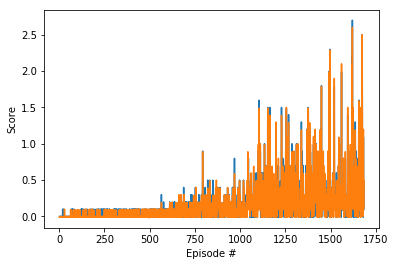

In [10]:
def ddpg(n_episodes=NUM_EPISODES):
    priority = PRE_PRIORITY_START
    print_step = 100
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = 0
    for i_episode in range(1, n_episodes+1):
        states = env.reset()
        agent.reset()
        score = np.zeros(env.num_agents)
        priority = max(priority*PRE_PRIORITY_DECAY, PRE_PRIORITY_END)
        while True:
            actions = agent.act(states, add_noise=USE_NOISE)                        # select an action (for each agent)
            next_states, rewards, dones, _ = env.step(actions)

            agent.step(states, actions, rewards, next_states, dones, priority)
            score += rewards                                  # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            
            if np.any(dones):                                  # exit loop if episode finished
                break
        
        scores_deque.append(score)
        scores.append(score)
        avg_score_ep = np.mean(score)
        avg_score_100 = np.mean(scores_deque)
        print('\rEpisode {}\t Score: {:.2f} \tAverage Score: {:.2f}'.format(i_episode,avg_score_ep, avg_score_100 ), end="")
        
        if i_episode % print_step == 0:
            print('')
        
        if avg_score_100>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, avg_score_100))
            if avg_score_100 > max_score:
                filename_template = '{}-EP_{}-score_{:.3f}.pth'
                filename_actor = filename_template.format('actor', i_episode, avg_score_100)
                filename_critic = filename_template.format('critic', i_episode, avg_score_100)
                
                torch.save(agent.actor_local.state_dict(), filename_actor)
                torch.save(agent.critic_local.state_dict(), filename_critic)
                
            break
                
    return scores

scores = ddpg()
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()